ในการทำโจทย์นี้ ใช้ ***[ref](https://www.kaggle.com/code/anshuls235/time-series-forecasting-eda-fe-modelling/notebook)*** นี้
ในส่วนที่ 2-3

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')


### 1 Fetch Data

In [9]:
calendar = pd.read_csv('m5-forecasting-accuracy\calendar.csv')
calendar.name = 'calendar'
sales = pd.read_csv('m5-forecasting-accuracy\sales_train_evaluation.csv')
sales.name = 'sales'
prices = pd.read_csv('m5-forecasting-accuracy\sell_prices.csv')
prices.name = 'prices'

In [10]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

### 2 Downcast

In [ ]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)

        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)

        elif 'object' in str(t):
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
sales.to_csv('m5-forecasting-accuracy\sales_train_evaluation.csv',index=False)

prices = downcast(prices)
prices.to_csv('m5-forecasting-accuracy\sell_prices.csv',index=False)

calendar = downcast(calendar)
calendar.to_csv('m5-forecasting-accuracy\calendar.csv',index=False)


### 3 Prepare Data - Feature engineering

In [ ]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

df.to_pickle('data_downcasted.pkl')


In [11]:
df = pd.read_pickle('data_downcasted.pkl')
#Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [12]:

df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

df.drop('date',axis=1,inplace=True)

In [13]:
#Introduce lags
lags = [1,2,7,14,21,30]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold']\
        .shift(lag).astype(np.float16)

In [14]:
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

In [15]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold']\
    .transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

In [16]:
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold']\
    .transform(lambda x: x.expanding(2).mean()).astype(np.float16)

In [17]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold']\
    .transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold']\
    .transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

In [20]:
df = df[df['d']>=36]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58967660 entries, 1067150 to 60034809
Data columns (total 42 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int16  
 1   item_id                   int16  
 2   dept_id                   int8   
 3   cat_id                    int8   
 4   store_id                  int8   
 5   state_id                  int8   
 6   d                         int16  
 7   sold                      int16  
 8   wm_yr_wk                  int16  
 9   weekday                   int8   
 10  wday                      int8   
 11  month                     int8   
 12  year                      int16  
 13  event_name_1              int8   
 14  event_type_1              int8   
 15  event_name_2              int8   
 16  event_type_2              int8   
 17  snap_CA                   int8   
 18  snap_TX                   int8   
 19  snap_WI                   int8   
 20  sell_price      

In [26]:
df.to_pickle('data.pkl')
del df

ชุดข้อมูลที่ผ่านการทำ Prepare Data & Feature Engineering แล้ว
ตอนนี้จะมีฟีเจอร์ที่นำไปใช้ได้คือ 41 ตัวแปร

### 4 Modeling

In [27]:
data = pd.read_pickle('data.pkl')
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

โมเดลปรับมาใช้เป็น XGBRegressor

ซึ่งข้อมูลที่ใช้เทรนจะไปดึงตาม stor_id [CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3]
จากนั้นจะแบ่งให้
* ช่วงวันที่ 1-1913 เป็นข้อมูลเทรน
* ช่วงวันที่ 1914 - 1942 เป็นชุดตรวจสอบ
* ช่วงวันที่ 1942 เป็นต้นไป( 28 วันหลังจากนั้น) เป็นตัววัดผล

In [94]:
from xgboost import XGBRegressor
import  joblib
#Get the store ids
stores = np.arange(10)
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)

    #Train and validate
    model = XGBRegressor(   objective='reg:squarederror',
                            booster = 'gblinear',
                            n_estimators=500, 
                            eta=0.3, 
                            seed = 20
    )

    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model-XGB/model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid

*****Prediction for Store: CA_1*****
[0]	validation_0-rmse:1.80809	validation_1-rmse:1.68130
[20]	validation_0-rmse:0.45389	validation_1-rmse:0.40084
[40]	validation_0-rmse:0.30971	validation_1-rmse:0.25106
[60]	validation_0-rmse:0.23531	validation_1-rmse:0.18195
[80]	validation_0-rmse:0.18219	validation_1-rmse:0.13789
[100]	validation_0-rmse:0.14188	validation_1-rmse:0.10611
[120]	validation_0-rmse:0.11087	validation_1-rmse:0.08298
[140]	validation_0-rmse:0.08680	validation_1-rmse:0.06515
[160]	validation_0-rmse:0.06810	validation_1-rmse:0.05133
[180]	validation_0-rmse:0.05355	validation_1-rmse:0.04053
[200]	validation_0-rmse:0.04222	validation_1-rmse:0.03214
[220]	validation_0-rmse:0.03340	validation_1-rmse:0.02553
[240]	validation_0-rmse:0.02657	validation_1-rmse:0.02039
[260]	validation_0-rmse:0.02125	validation_1-rmse:0.01640
[280]	validation_0-rmse:0.01714	validation_1-rmse:0.01327
[300]	validation_0-rmse:0.01397	validation_1-rmse:0.01085
[320]	validation_0-rmse:0.01154	validatio

In [108]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir('model-XGB/'):
    if 'model' in filename:
        # load model
        model = joblib.load('model-XGB/'+filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)

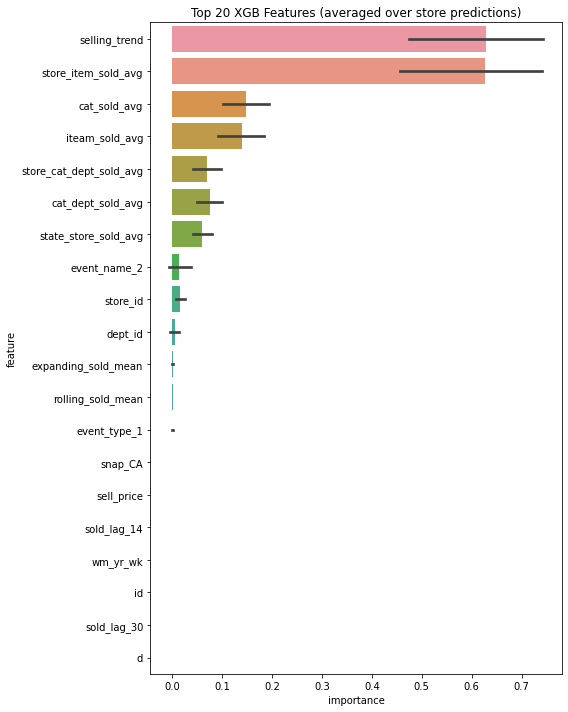

In [109]:
import seaborn as sns
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Top 20 XGB Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

จากภาพข้างต้น จะเห็นว่า โมเดลให้ความสำคัญกับตัวแปร selling_trend, store_item_sold_avg, cat_sold_avg, item_sold_avg และ store_cat_dept_old_avg ตามลำดับ

In [148]:


#Get the actual validation results
valid['sold'] = valid_preds
validation = valid[['id','d','sold']]
types = validation.dtypes.values.tolist()
ols = validation.dtypes.index.tolist()
for i,t in enumerate(types):
    if 'float' in str(t): validation[cols[i]] = validation[cols[i]].astype(np.int8)
validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
types = submit.dtypes.values.tolist()
cols = submit.dtypes.index.tolist()
for i,t in enumerate(types):
        if 'float' in str(t): submit[cols[i]] = submit[cols[i]].astype(np.int8)

submit.to_csv('m5-forecasting-accuracy/submission-XGB.csv',index=False)
submit

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,2,0,0,0,0,1,1,0,6,...,2,3,1,0,0,0,1,0,0,0
1,FOODS_1_001_CA_2_validation,0,3,0,0,0,1,4,0,0,...,1,0,0,1,1,0,0,1,2,0
2,FOODS_1_001_CA_3_validation,0,0,0,0,7,0,0,0,0,...,0,1,1,0,0,0,0,2,1,1
3,FOODS_1_001_CA_4_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FOODS_1_001_TX_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_TX_2_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,HOUSEHOLD_2_516_TX_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,HOUSEHOLD_2_516_WI_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,HOUSEHOLD_2_516_WI_2_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


เช็คว่าโมเดลสามารถทำนายผล(validation)ได้เหมือนกับ validation จริงจากไฟล์ sale_train_validation.csv ไหม

In [116]:
validation_actual = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
validation_actual['id']=pd.read_csv('m5-forecasting-accuracy/sales_train_validation.csv').id
validation_actual.columns=['id'] + ['F' + str(i + 1) for i in range(28)]

In [202]:
test_is_eq = pd.concat([validation_actual, validation])
test_is_eq = test_is_eq.reset_index(drop=True)
test_is_eq_gpby = test_is_eq.groupby(list(test_is_eq.columns))
idx = [x[0] for x in test_is_eq_gpby.groups.values() if len(x) == 1]
test_is_eq.reindex(idx)
acc = 0.0
for id_ in validation.id.unique().tolist():
    t = test_is_eq[test_is_eq['id']==id_].to_numpy()
    acc+=np.mean(t[0,1:] == t[1,1:])/30490 # actual==predict?

acc

0.7606744600102484

คิดเป็น accuracy ได้ประมาณ 76.07%